In [31]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import play_song as song
import feature_selection as fs

In [2]:
## Load and temp PREPROC

In [3]:
df = pd.read_csv('./project_data/out_eda1.csv', 
                 index_col = 'Claim Identifier')

In [4]:
df = df.dropna()

In [6]:
# Example usage in evaluate_features function:
X, y = df.drop(columns=['Claim Injury Type']), df['Claim Injury Type']

In [7]:
num = ['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'IME-4 Count', 'Number of Dependents',
       'Accident Year', 'Accident Month', 'Accident Day', 'Assembly Year', 'Assembly Month', 'Assembly Day',
       'C-2 Year', 'C-2 Month', 'C-2 Day', 'First Hearing Year']

categ = ['Alternative Dispute Resolution', 'Attorney/Representative', 'Carrier Name', 'Carrier Type',
         'County of Injury', 'COVID-19 Indicator', 'District Name', 'Gender',
         'Industry Code', 'Medical Fee Region', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
         'WCIO Part Of Body Code', 'Zip Code', 'C-3 Date Binary' ]

In [8]:
## EVAL function

In [34]:
from sklearn.metrics import classification_report
from collections import Counter
import time

def evaluate_features(df, num, categ, 
                      rfe_features, rfe_model, k=5):
    
    start_time = time.time()
    
    X, y = df.drop(columns=['Claim Injury Type']), df['Claim Injury Type']
    kf = KFold(n_splits=k)
    selected_features = []

    for train_idx, val_idx in kf.split(X):
        
        print(f'------------ FOLD ------------ \n')
        start_time = time.time()
        
        # train & val
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Numerical
        print('----LASSO----')
        lasso = fs.lasso(X_train, y_train, num)
        print('----RFE----')
        # for model in rfe_model: ## FUTURE
        rfe = fs.rfe(X_train, y_train, num, rfe_features, rfe_model)
        print('----CORR----')
        corr = fs.correlation_matrix(X_train, num)
        #print('----VAR----')
        var = fs.var(X_train, num)
        
        # Categorical
        print('----CHI2----')
        chi2 = fs.chi_squared(X_train, y_train, categ)
        print('----MI----')
        mutual_information = fs.mutual_information(X_train, y_train, categ)
        
        
        # Combine selected features from each method
        num_selected = set(lasso).union(rfe, corr, var)
        categ_selected = set(chi2).union(mutual_information)

        # Filter training and validation sets based on selected features
        num_selected = [feature for feature in num_selected if isinstance(feature, str)]
        
        #num_selected = num_selected.to_list()
        categ_selected = list(categ_selected)
        
        X_train_selected = X_train[num_selected + categ_selected]
        X_val_selected = X_val[num_selected + categ_selected]
        
        
        # Train model and record performance
        model = LogisticRegression()
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_val_selected)
        
        # Print classification report for current fold
        print('CLASSIFICATION REPORT \n')
        print(classification_report(y_val, y_pred))

        # Save selected features for counting occurrences
        selected_features.append(num_selected + categ_selected)

        # End timing
        end_time1 = time.time()
        elapsed_time1 = end_time1 - start_time
        print(elapsed_time1)
    
    # Count occurrences of each feature across folds
    feature_counts = Counter(np.concatenate(selected_features))
    
    song.play_('audio.mp3')
    # End timing
    end_time2 = time.time()
    elapsed_time2 = end_time2 - start_time
    print(elapsed_time2)
    
    # Select only features that appear in all folds
    final_features = [feature for feature, count in feature_counts.items() if count == k]
    return final_features


------------ FOLD [ 92117  92118  92119 ... 460579 460580 460581] ------------ 

----LASSO----


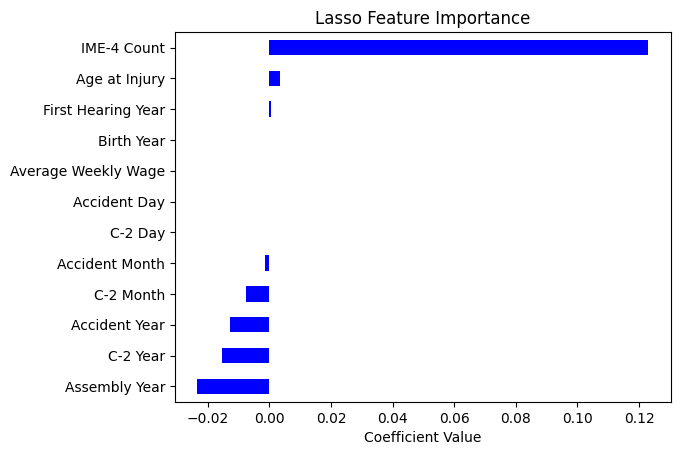

----RFE----
Trying with 12 features: 12 selected features.
Classification Report for 12 features:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3415
           2       1.00      1.00      1.00    187651
           3       1.00      0.99      0.99     46778
           4       1.00      1.00      1.00     98139
           5       1.00      1.00      1.00     29842
           6       1.00      1.00      1.00      2344
           7       1.00      1.00      1.00        48
           8       1.00      1.00      1.00       248

    accuracy                           1.00    368465
   macro avg       1.00      1.00      1.00    368465
weighted avg       1.00      1.00      1.00    368465

----CORR----


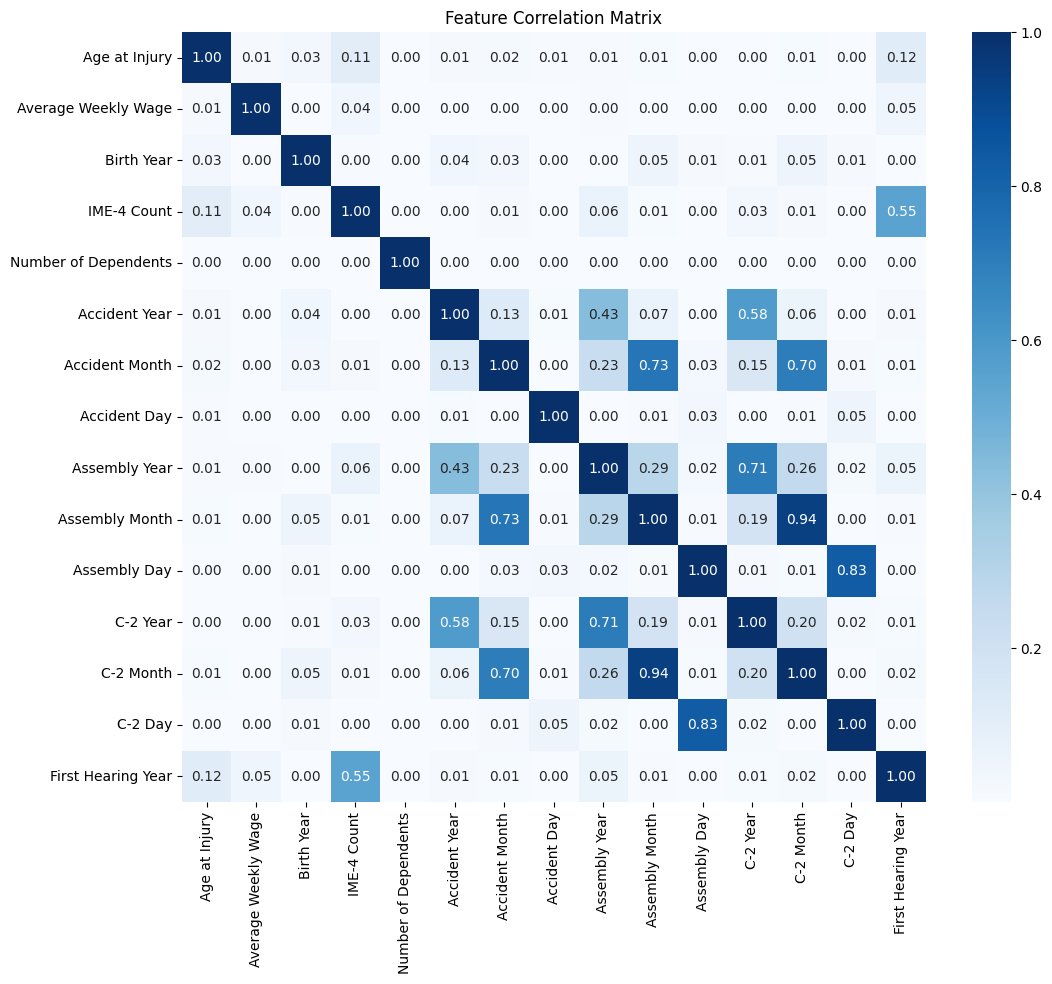

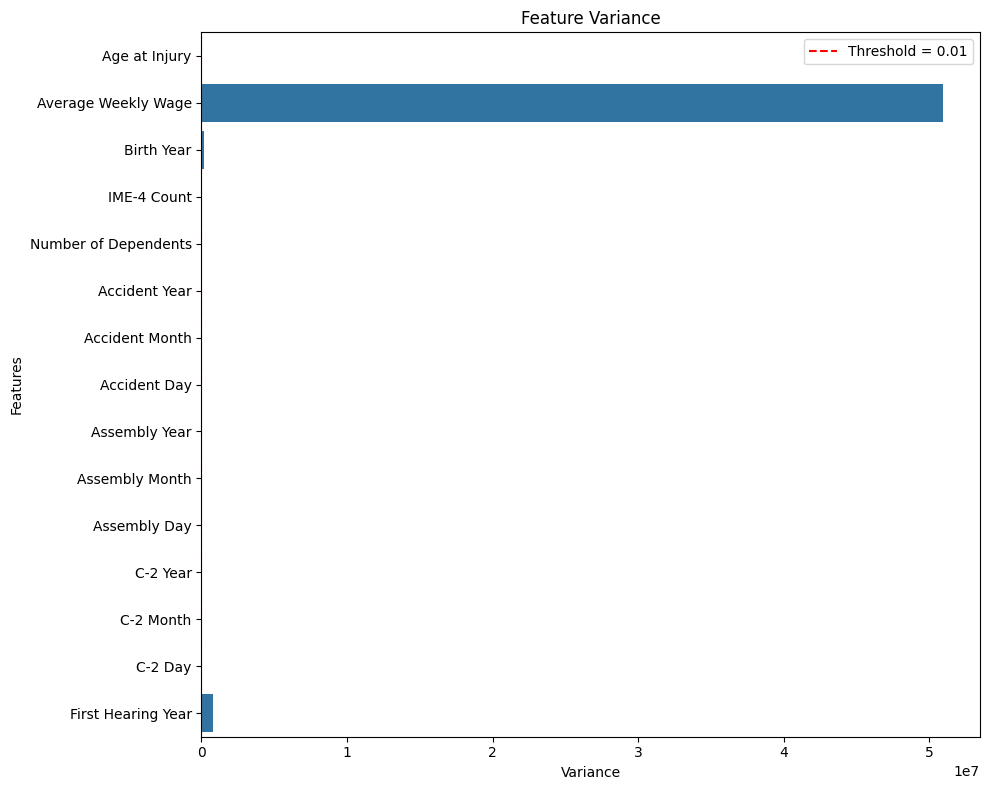

----CHI2----


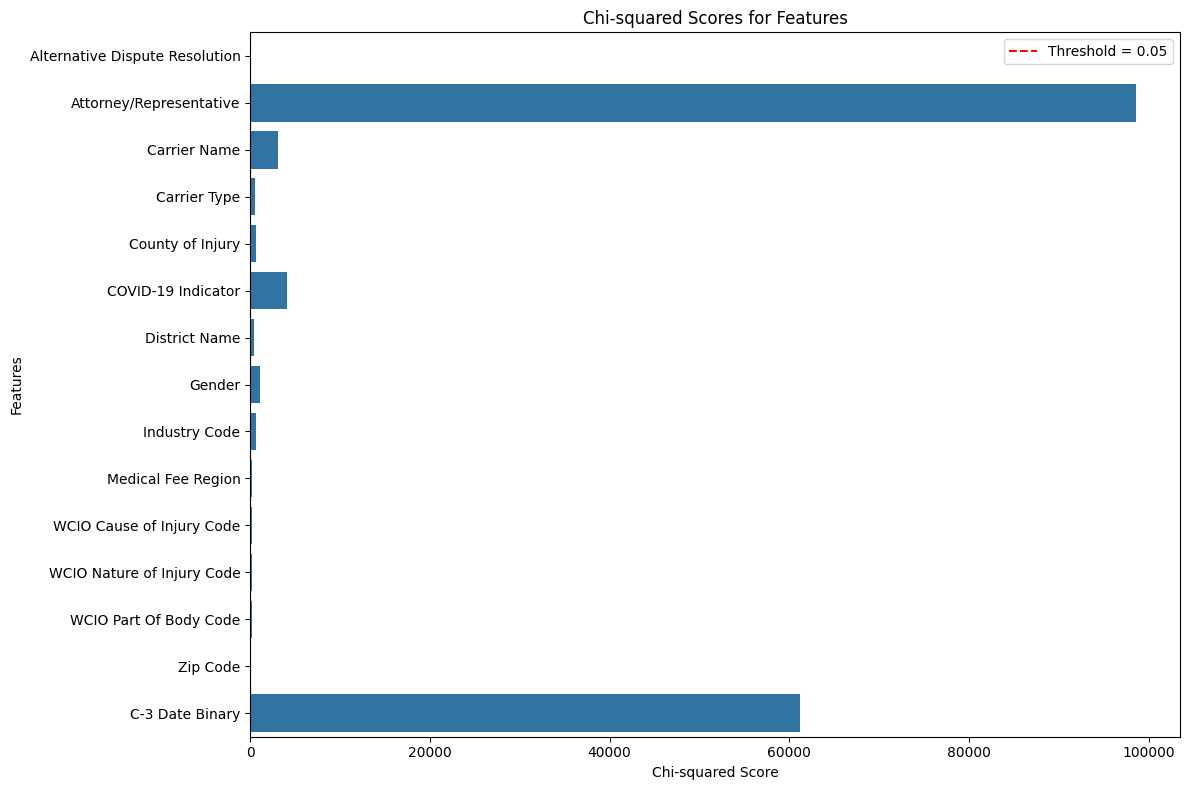

----MI----


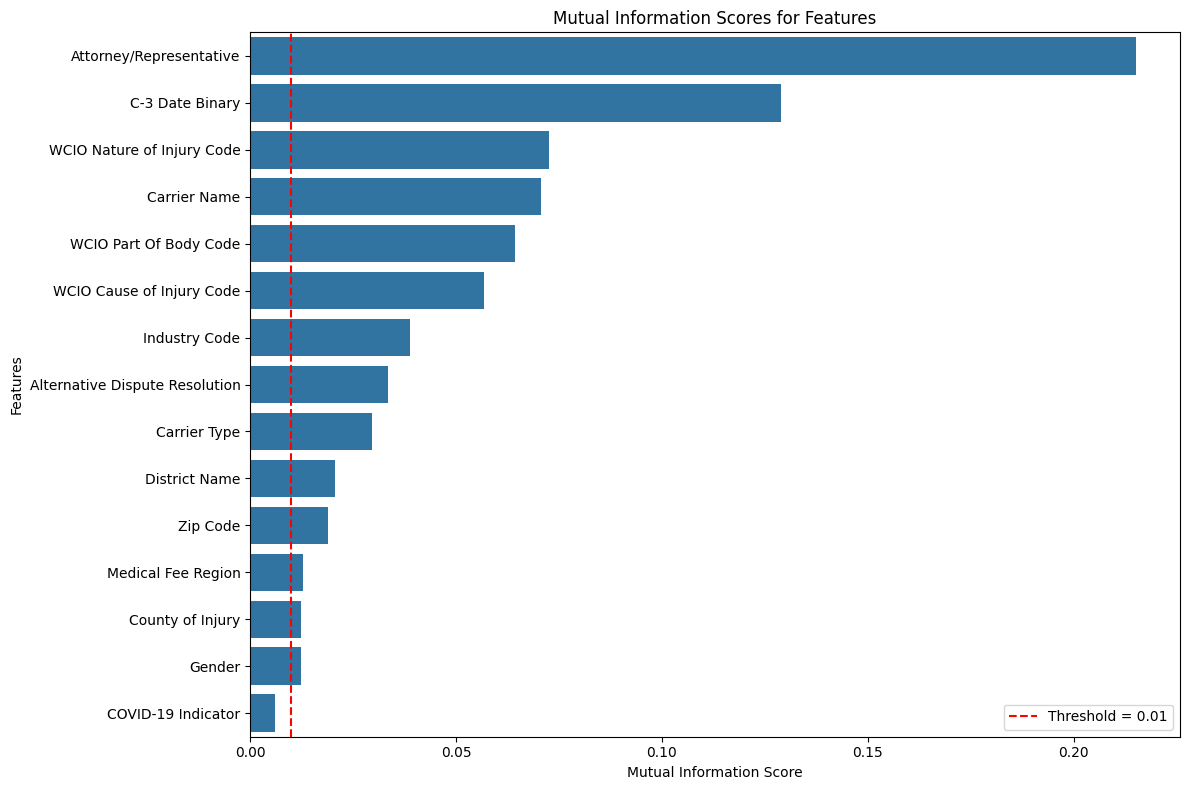

CLASSIFICATION REPORT 

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       826
           2       0.64      0.98      0.77     45596
           3       0.00      0.00      0.00      9994
           4       0.52      0.42      0.47     24351
           5       0.26      0.08      0.12     10081
           6       0.00      0.00      0.00      1114
           7       0.00      0.00      0.00        36
           8       0.00      0.00      0.00       119

    accuracy                           0.60     92117
   macro avg       0.18      0.18      0.17     92117
weighted avg       0.48      0.60      0.52     92117

402.93763303756714
------------ FOLD [     0      1      2 ... 460579 460580 460581] ------------ 

----LASSO----


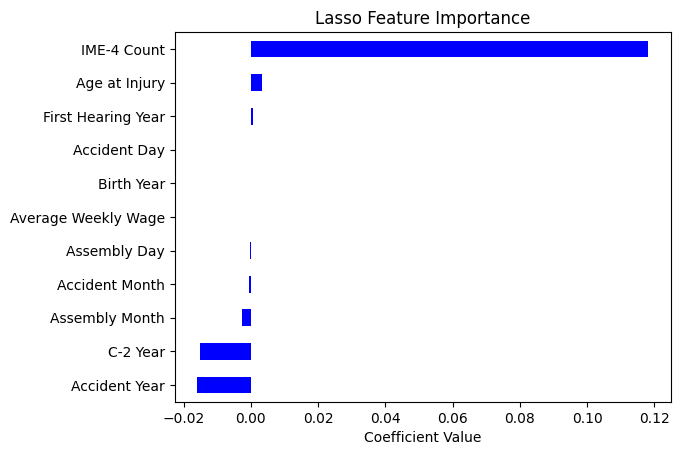

----RFE----
Trying with 12 features: 12 selected features.
Classification Report for 12 features:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3406
           2       1.00      1.00      1.00    188477
           3       1.00      0.99      1.00     47127
           4       1.00      1.00      1.00     97305
           5       1.00      1.00      1.00     29400
           6       1.00      1.00      1.00      2430
           7       1.00      1.00      1.00        57
           8       1.00      1.00      1.00       263

    accuracy                           1.00    368465
   macro avg       1.00      1.00      1.00    368465
weighted avg       1.00      1.00      1.00    368465

----CORR----


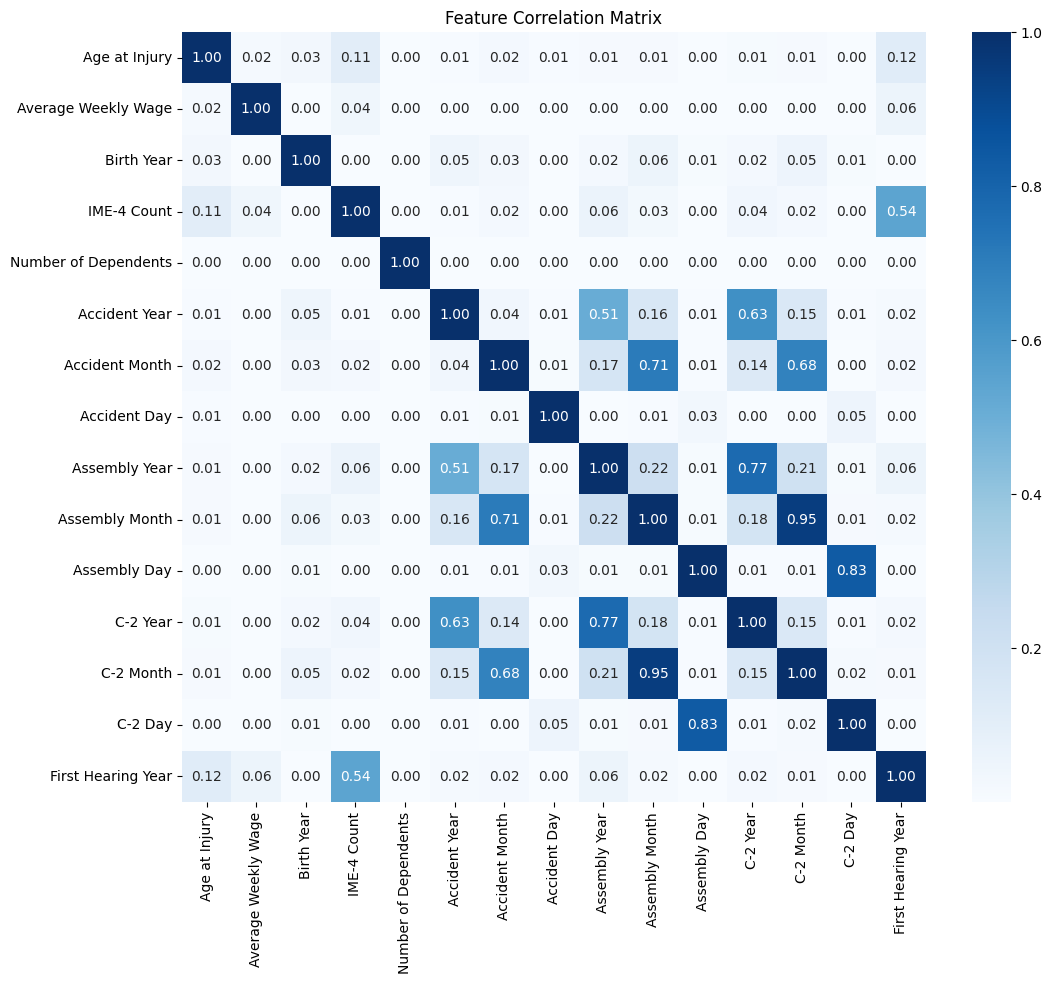

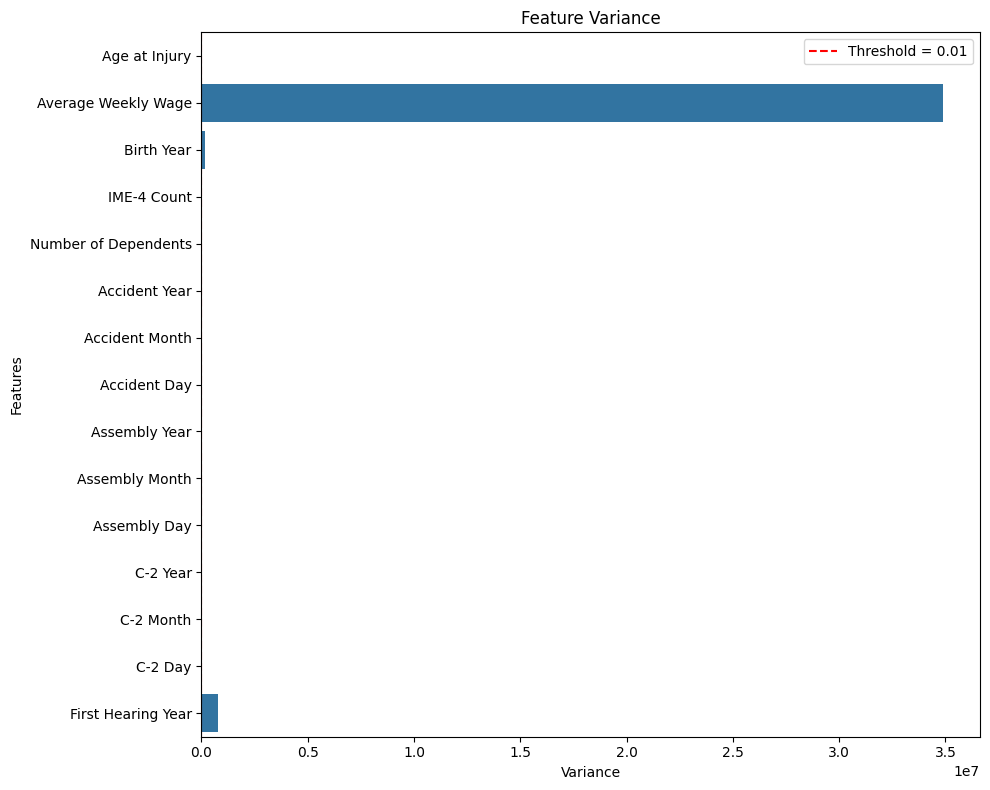

----CHI2----


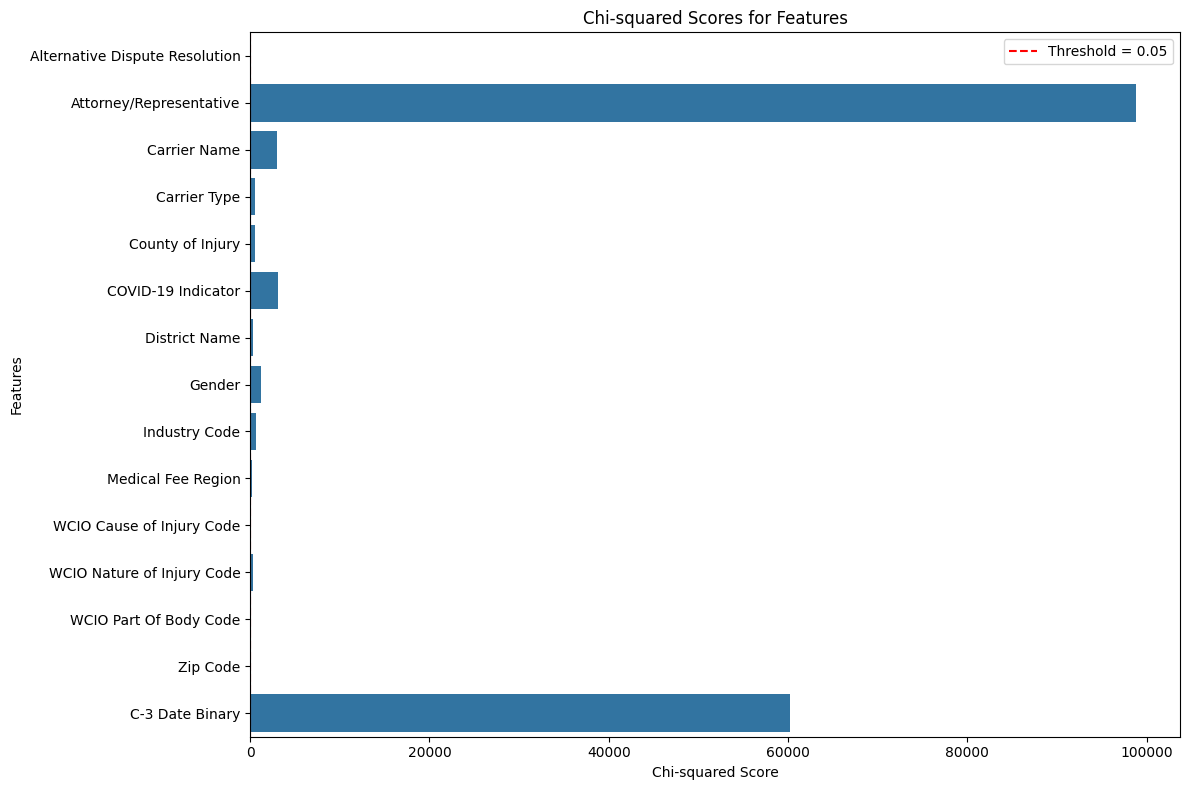

----MI----


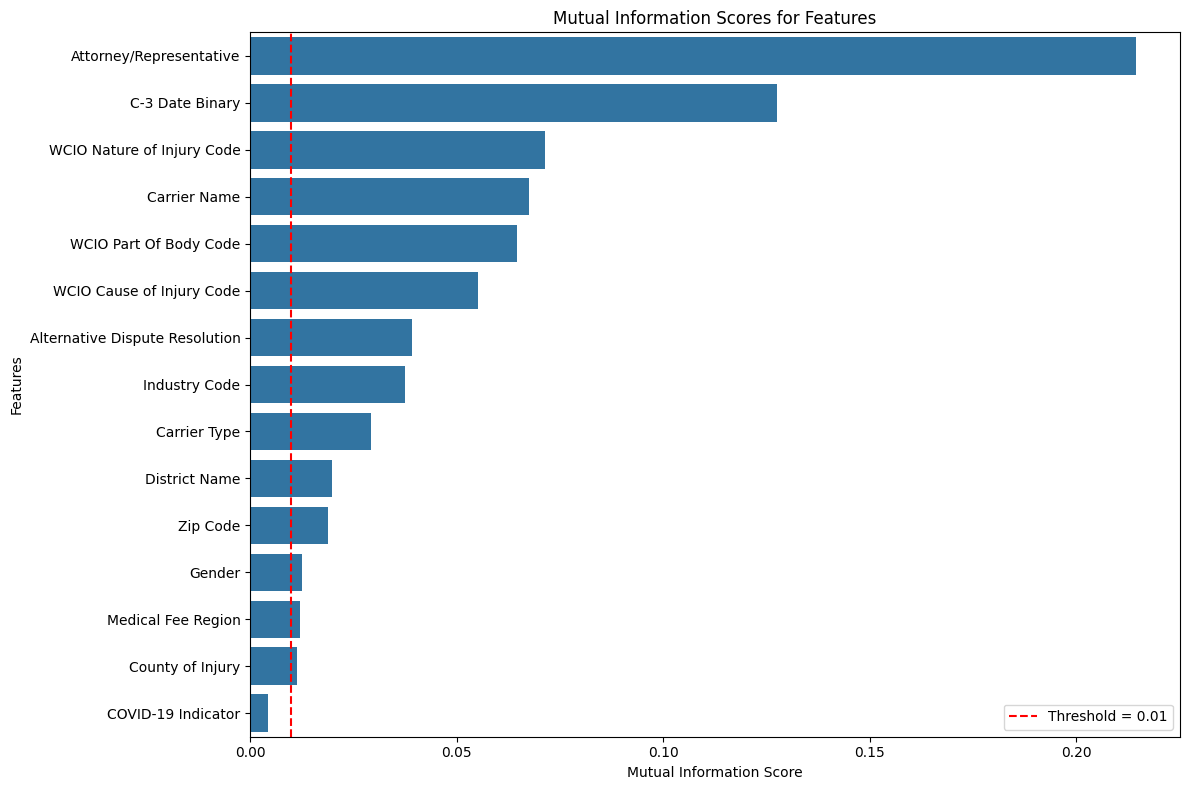

CLASSIFICATION REPORT 

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       835
           2       0.61      0.98      0.76     44770
           3       0.00      0.00      0.00      9645
           4       0.53      0.38      0.44     25185
           5       0.28      0.07      0.12     10523
           6       0.00      0.00      0.00      1028
           7       0.00      0.00      0.00        27
           8       0.00      0.00      0.00       104

    accuracy                           0.59     92117
   macro avg       0.18      0.18      0.16     92117
weighted avg       0.47      0.59      0.50     92117

798.3947441577911
------------ FOLD [     0      1      2 ... 460579 460580 460581] ------------ 

----LASSO----


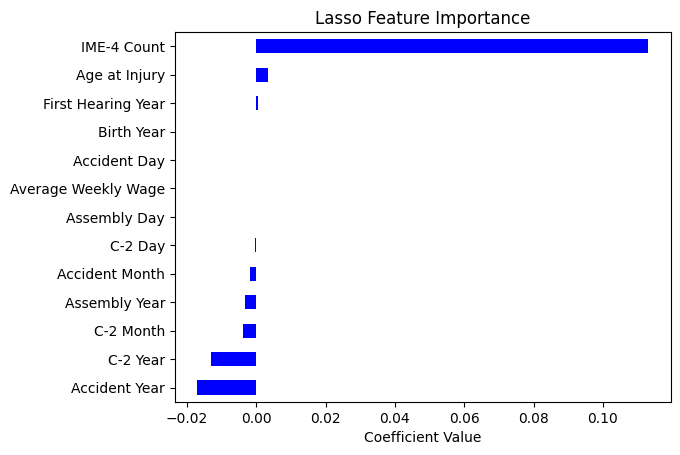

----RFE----
Trying with 12 features: 12 selected features.
Classification Report for 12 features:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3359
           2       1.00      1.00      1.00    188210
           3       1.00      0.99      1.00     44901
           4       1.00      1.00      1.00     97874
           5       1.00      1.00      1.00     31025
           6       1.00      1.00      1.00      2720
           7       1.00      1.00      1.00        71
           8       1.00      1.00      1.00       306

    accuracy                           1.00    368466
   macro avg       1.00      1.00      1.00    368466
weighted avg       1.00      1.00      1.00    368466

----CORR----


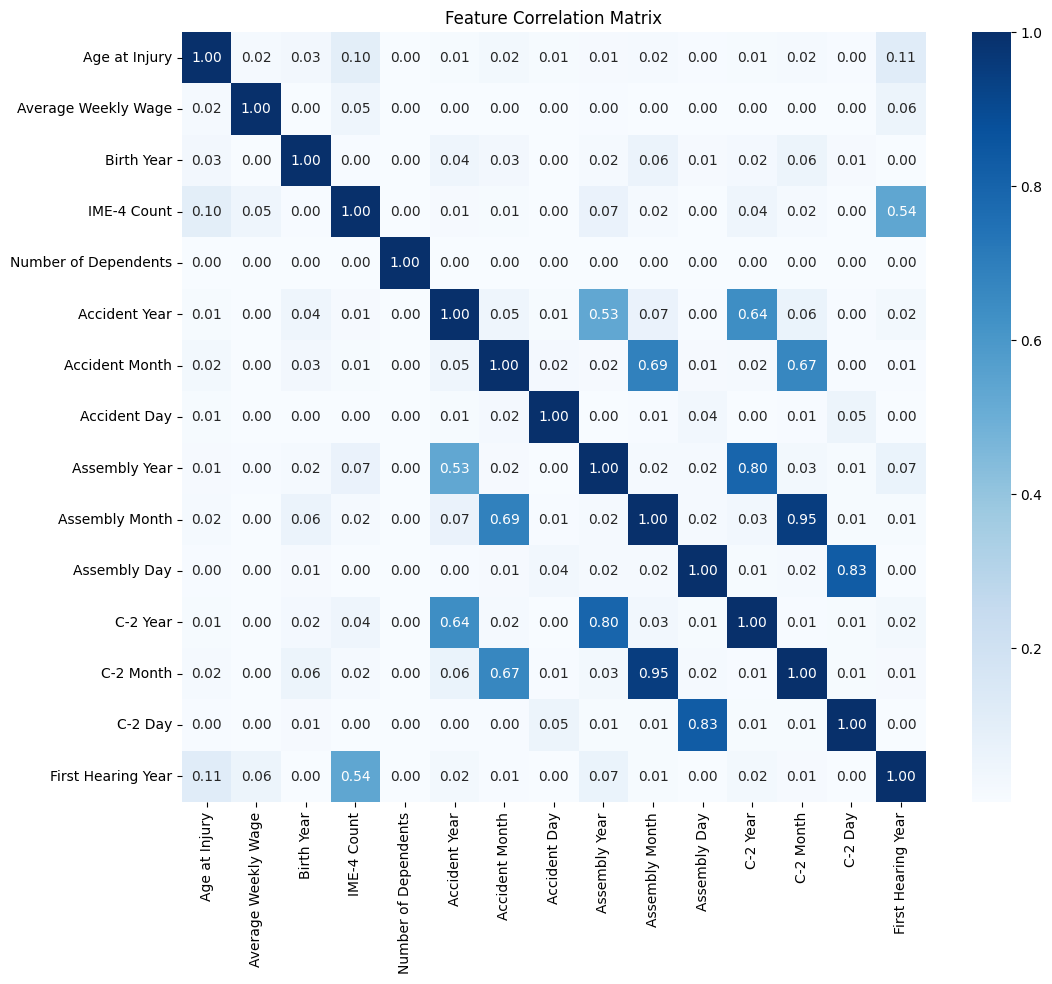

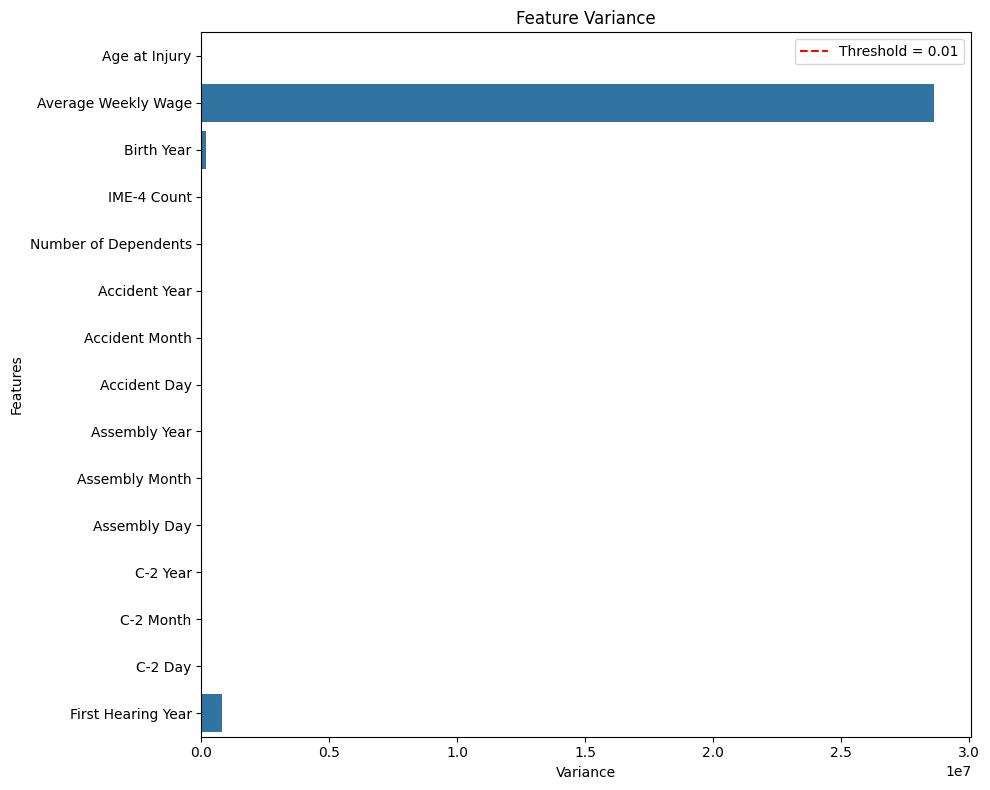

----CHI2----


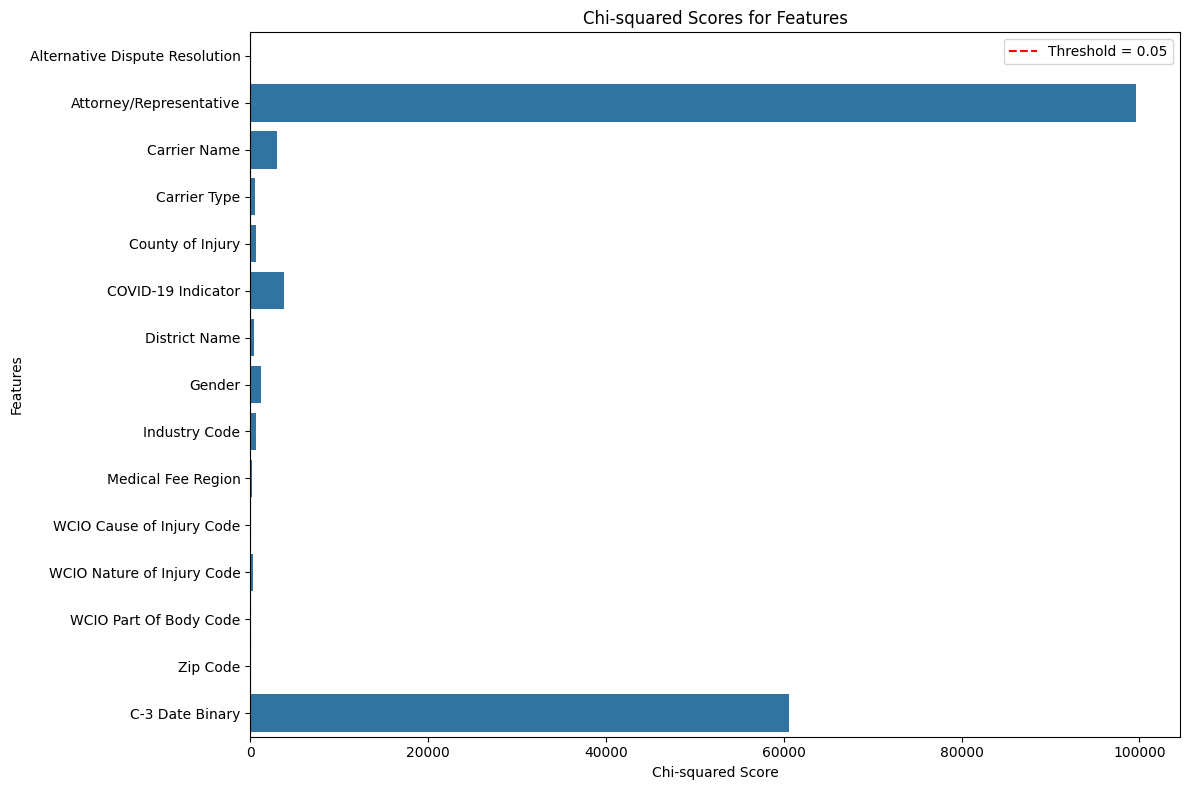

----MI----


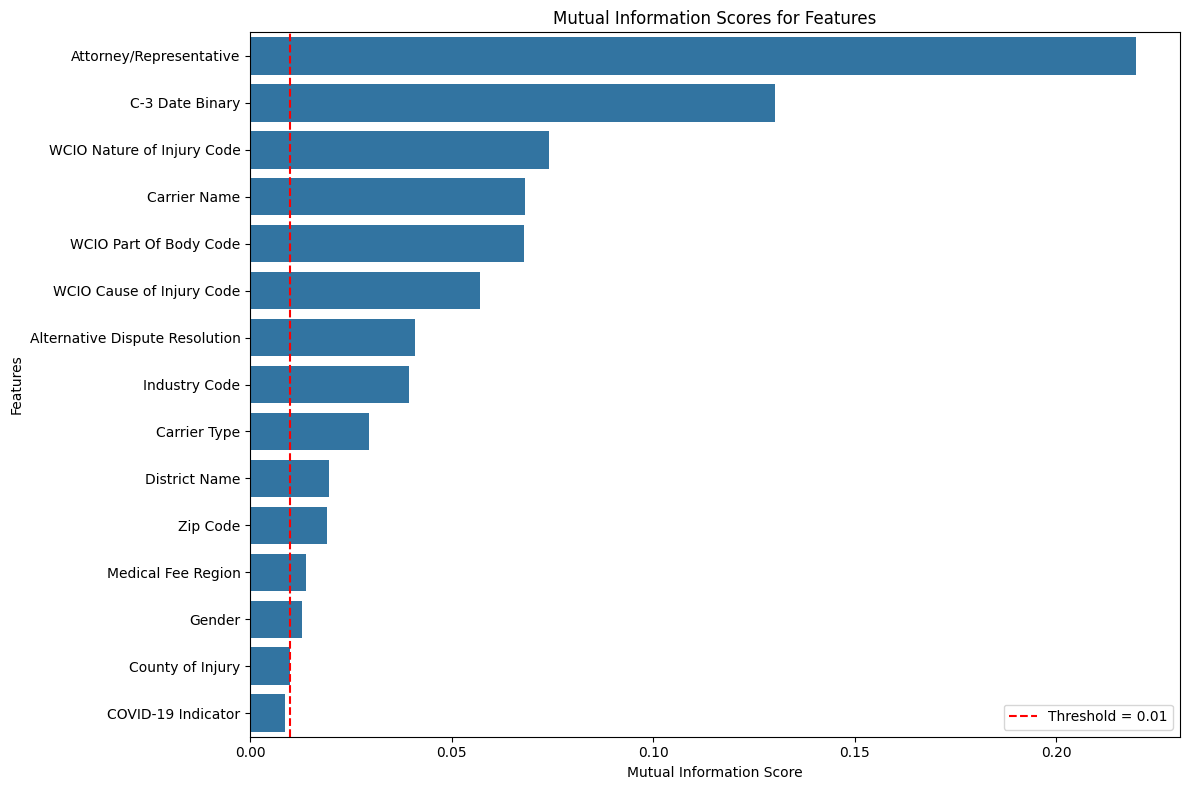

CLASSIFICATION REPORT 

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       882
           2       0.61      0.98      0.75     45037
           3       0.14      0.01      0.01     11871
           4       0.54      0.41      0.47     24616
           5       0.08      0.01      0.01      8898
           6       0.00      0.00      0.00       738
           7       0.00      0.00      0.00        13
           8       0.00      0.00      0.00        61

    accuracy                           0.59     92116
   macro avg       0.17      0.18      0.16     92116
weighted avg       0.47      0.59      0.50     92116

1216.6978492736816
------------ FOLD [     0      1      2 ... 460579 460580 460581] ------------ 

----LASSO----


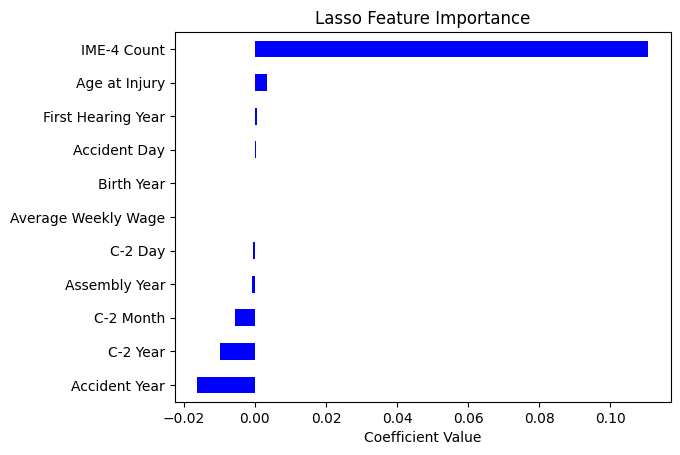

----RFE----
Trying with 12 features: 12 selected features.
Classification Report for 12 features:
              precision    recall  f1-score   support

           1       1.00      0.99      1.00      3389
           2       1.00      1.00      1.00    185195
           3       1.00      0.99      0.99     44749
           4       1.00      1.00      1.00     98333
           5       1.00      1.00      1.00     33369
           6       1.00      1.00      1.00      3036
           7       1.00      1.00      1.00        80
           8       1.00      1.00      1.00       315

    accuracy                           1.00    368466
   macro avg       1.00      1.00      1.00    368466
weighted avg       1.00      1.00      1.00    368466

----CORR----


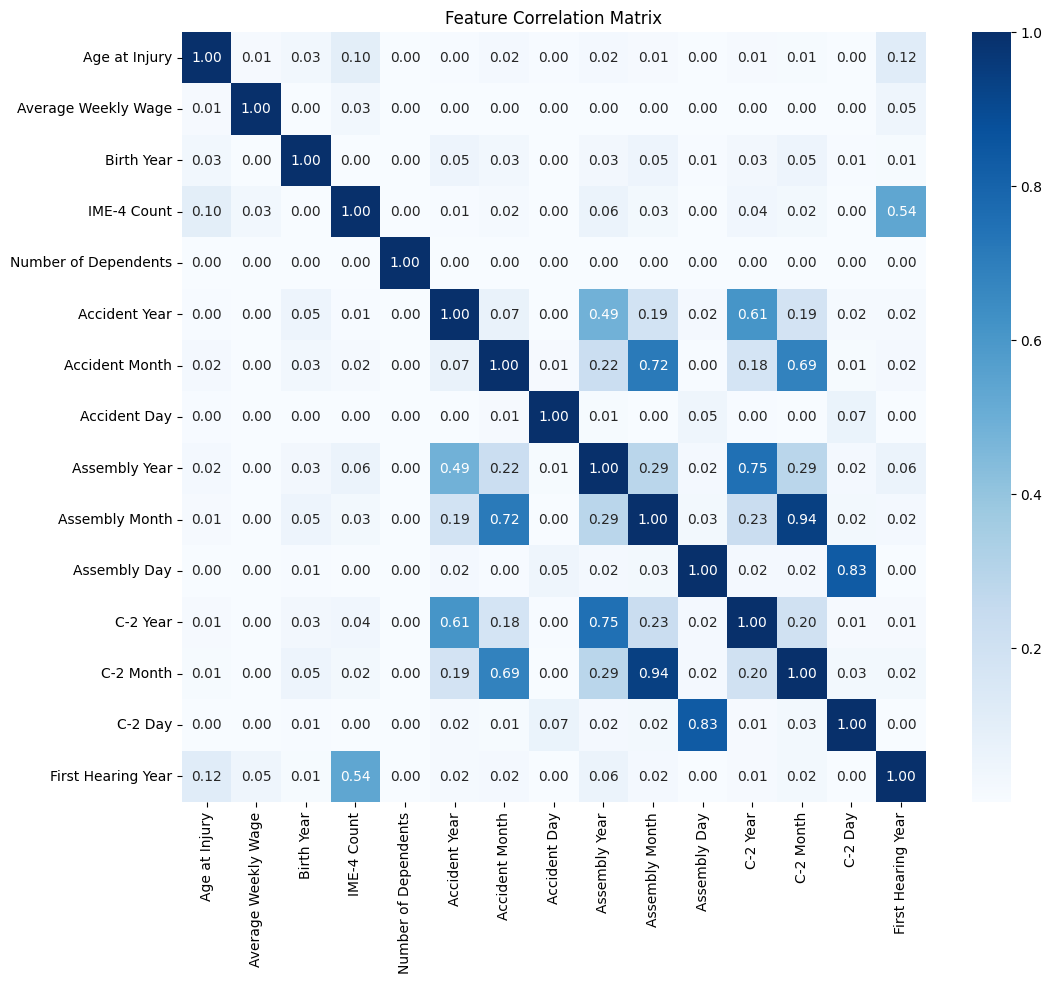

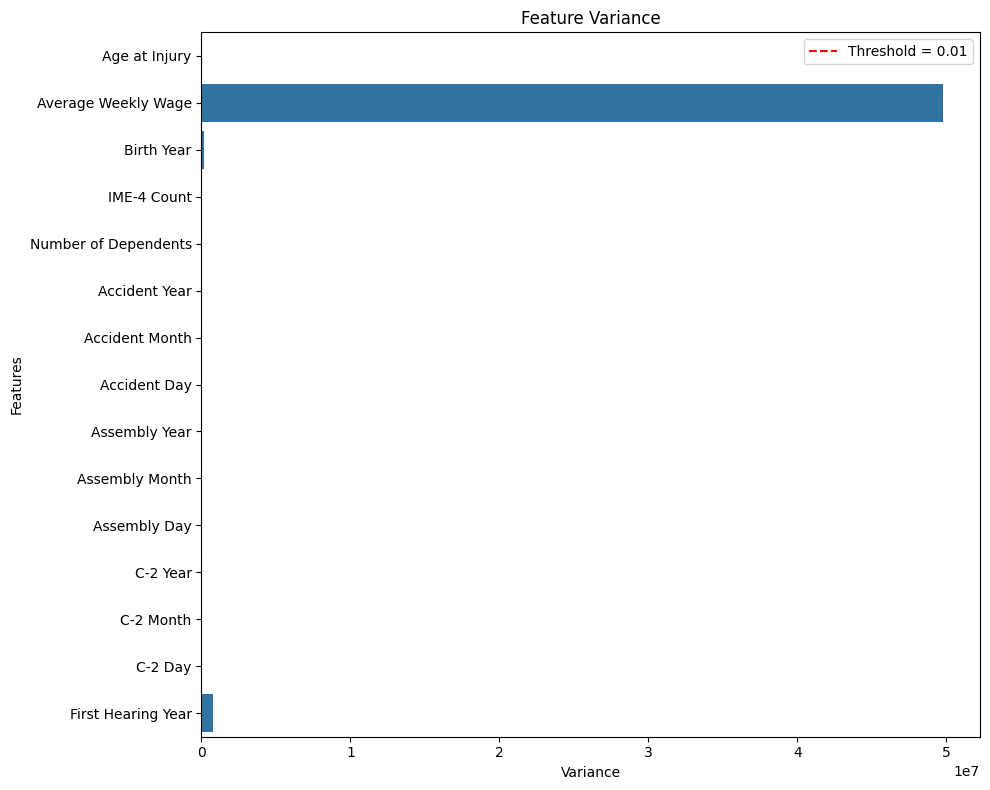

----CHI2----


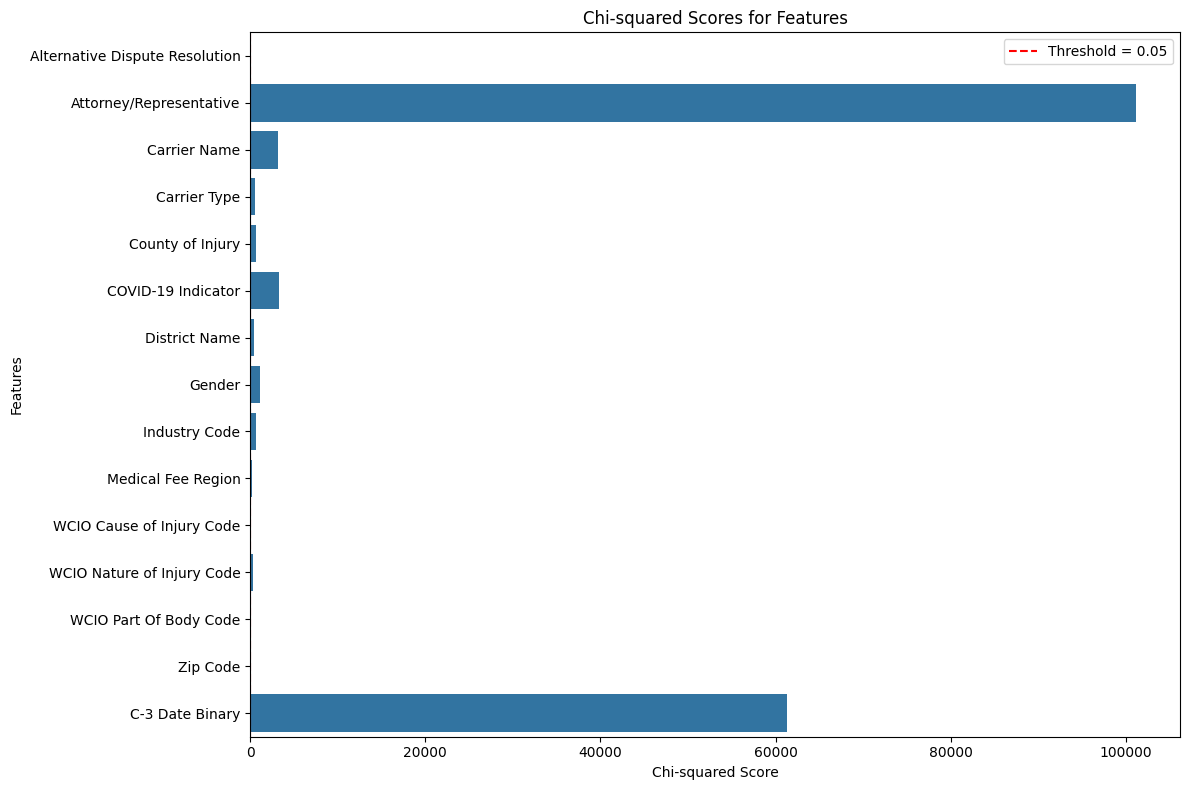

----MI----


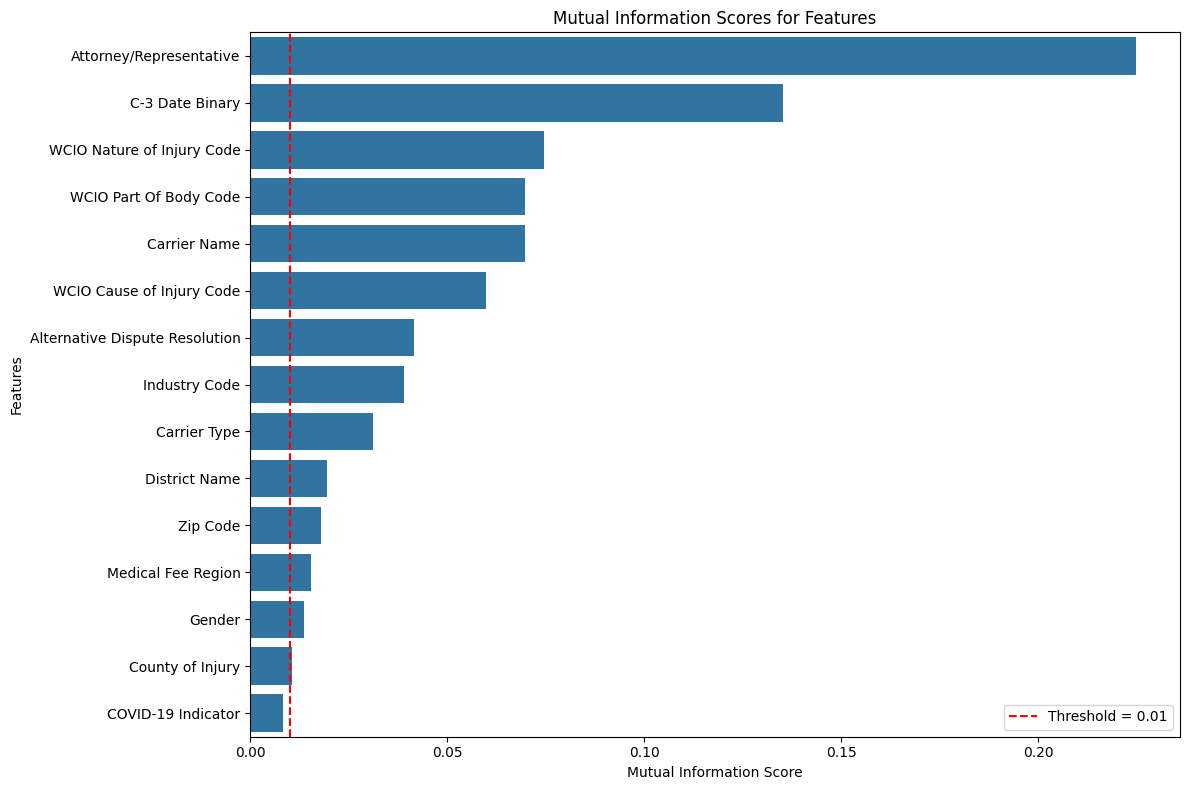

CLASSIFICATION REPORT 

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       852
           2       0.66      0.98      0.79     48052
           3       0.00      0.00      0.00     12023
           4       0.60      0.47      0.53     24157
           5       0.14      0.04      0.07      6554
           6       0.00      0.00      0.00       422
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00        52

    accuracy                           0.64     92116
   macro avg       0.17      0.19      0.17     92116
weighted avg       0.51      0.64      0.55     92116

1458.9927639961243
------------ FOLD [     0      1      2 ... 368463 368464 368465] ------------ 

----LASSO----


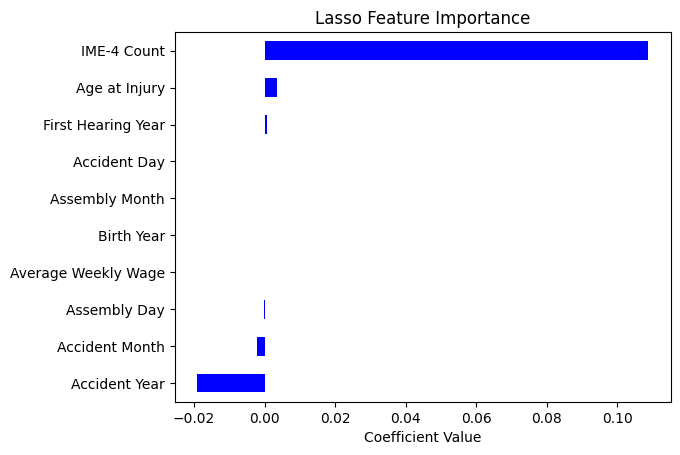

----RFE----
Trying with 12 features: 12 selected features.
Classification Report for 12 features:
              precision    recall  f1-score   support

           1       1.00      0.99      1.00      3395
           2       1.00      1.00      1.00    183455
           3       1.00      0.99      1.00     43533
           4       1.00      1.00      1.00     98309
           5       1.00      1.00      1.00     36056
           6       1.00      1.00      1.00      3302
           7       1.00      1.00      1.00        80
           8       1.00      1.00      1.00       336

    accuracy                           1.00    368466
   macro avg       1.00      1.00      1.00    368466
weighted avg       1.00      1.00      1.00    368466

----CORR----


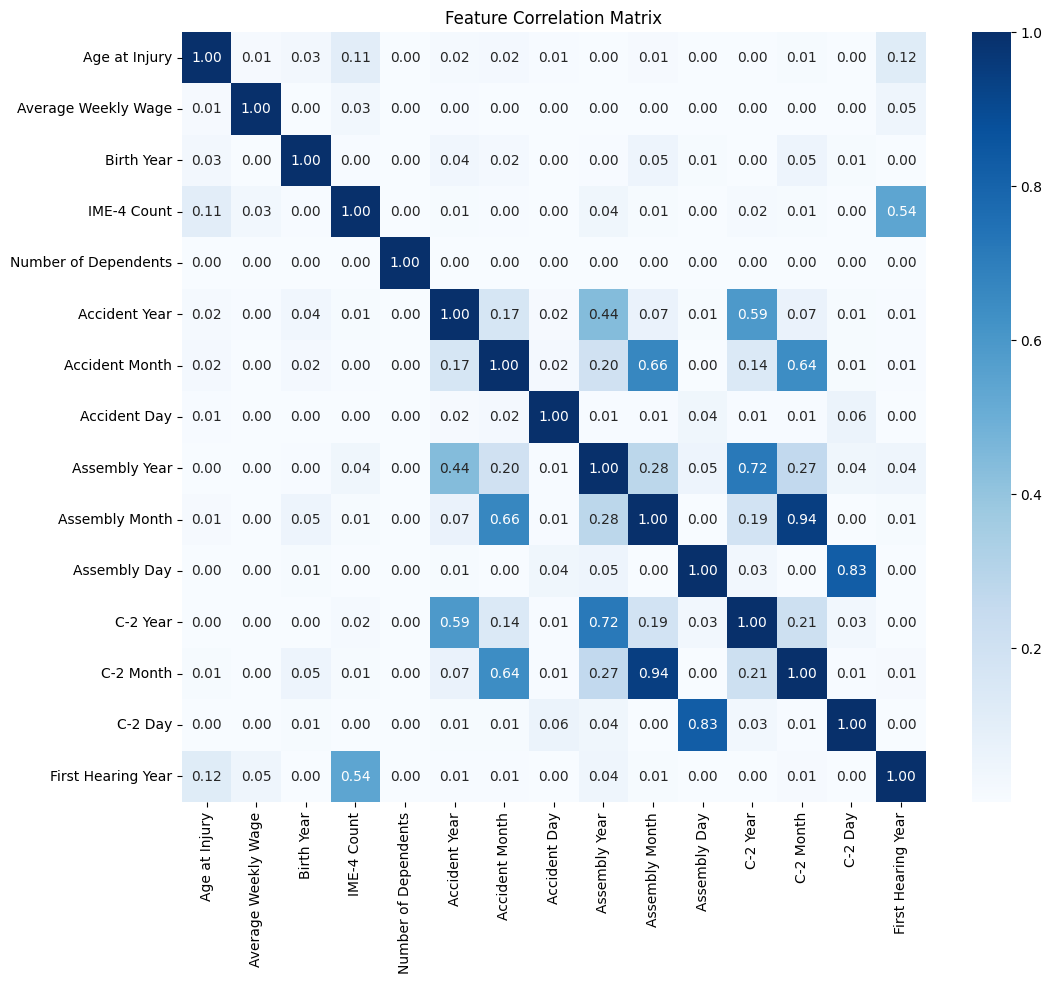

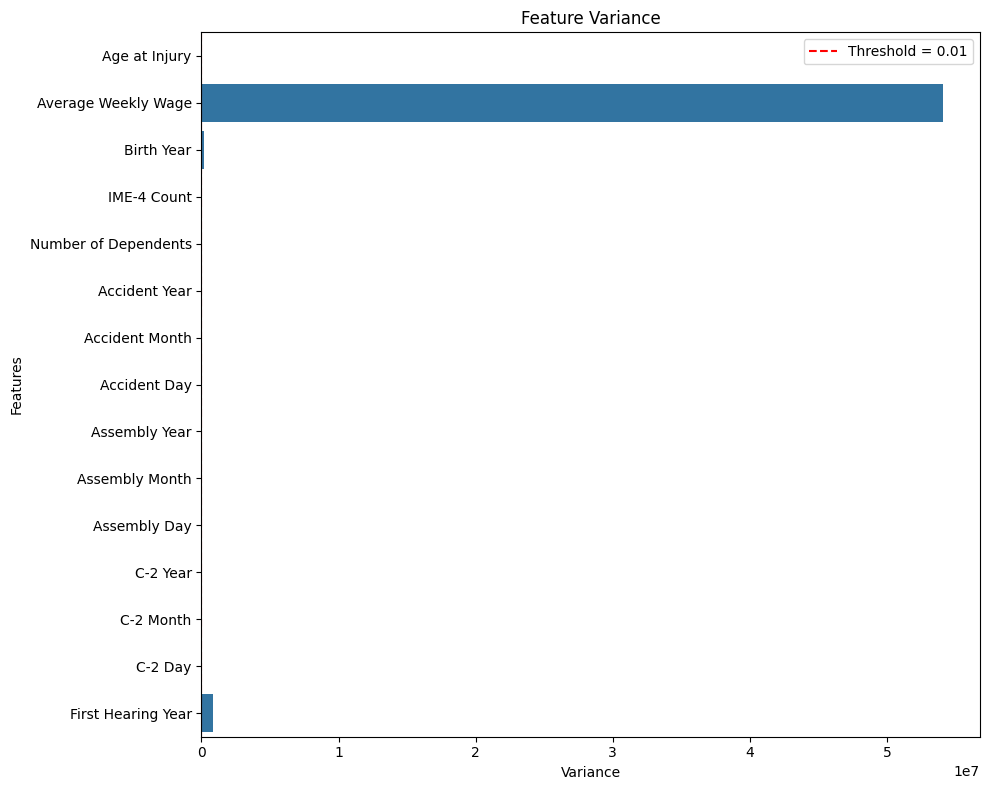

----CHI2----


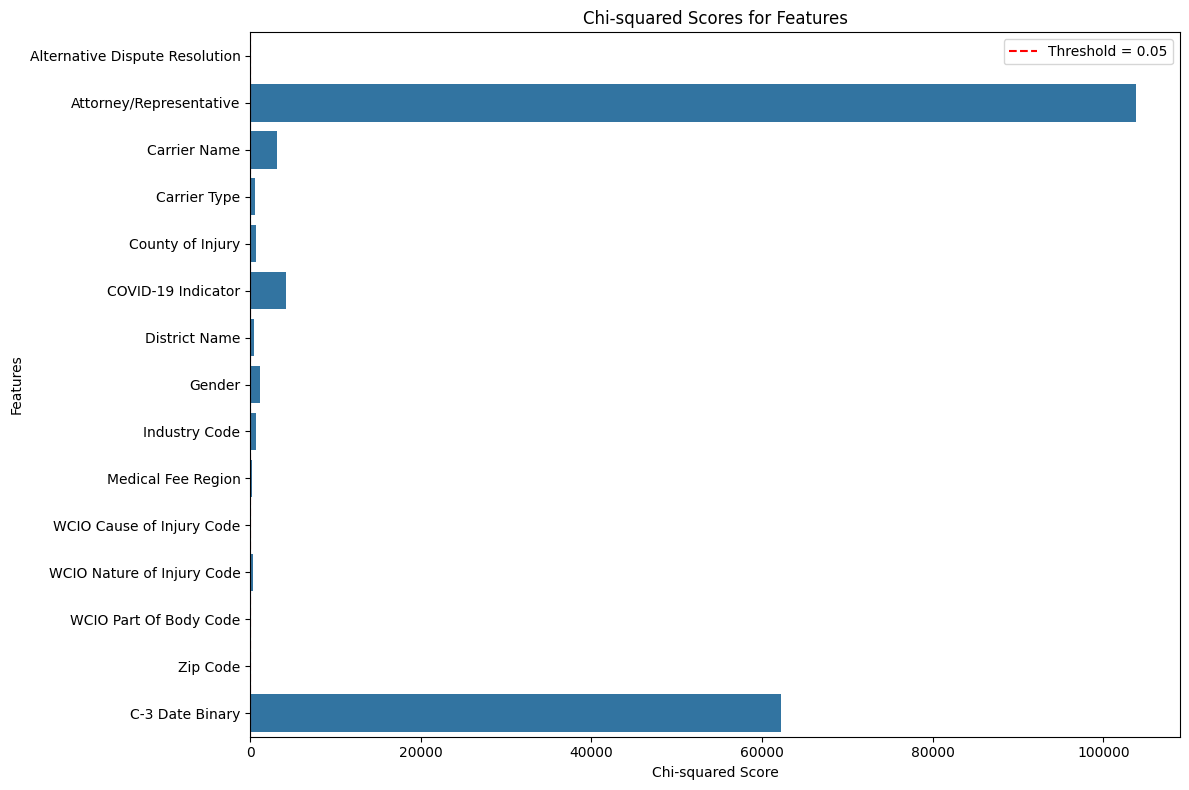

----MI----


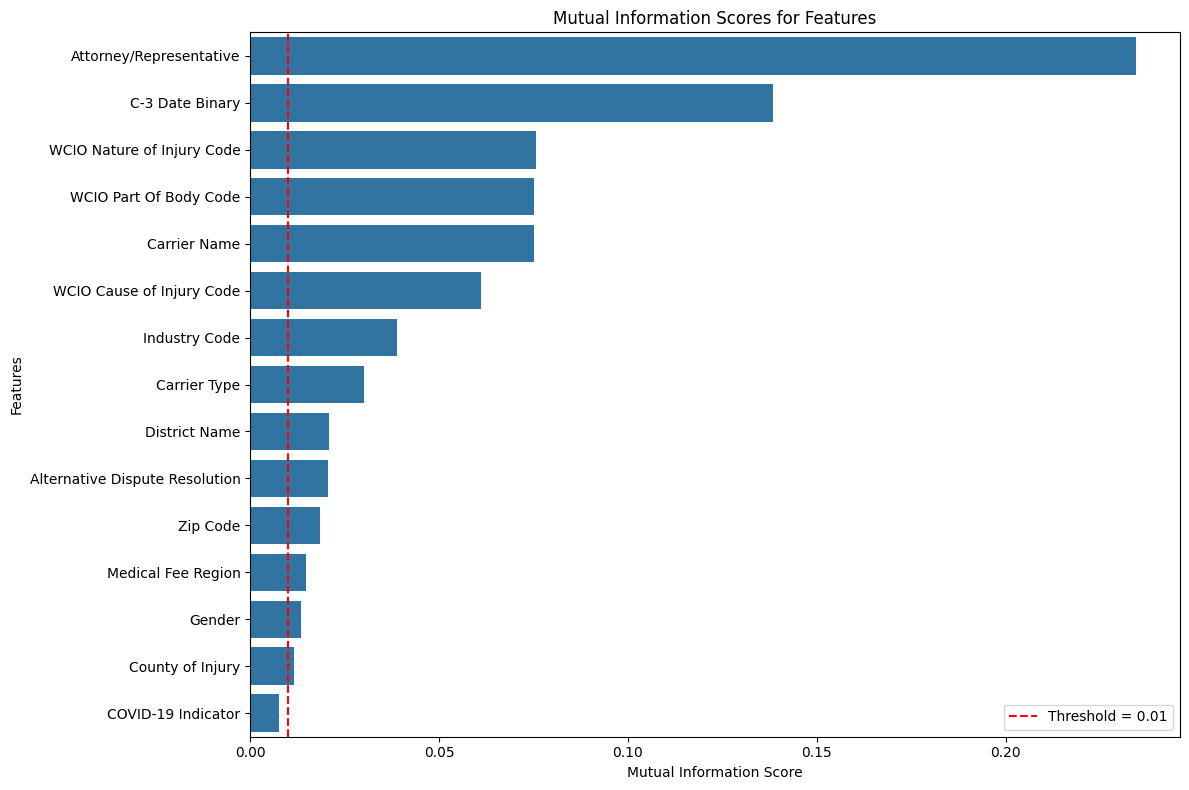

CLASSIFICATION REPORT 

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       846
           2       0.68      0.98      0.80     49792
           3       0.00      0.00      0.00     13239
           4       0.66      0.49      0.57     24181
           5       0.10      0.06      0.08      3867
           6       0.00      0.00      0.00       156
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00        31

    accuracy                           0.66     92116
   macro avg       0.18      0.19      0.18     92116
weighted avg       0.54      0.66      0.58     92116

1710.9059371948242


Input #0, wav, from '/var/folders/mm/fxsq_1490x9dd2w76tqvt3kr0000gn/T/tmpqrsb4_iq.wav':
  Duration: 00:00:10.00, bitrate: 1536 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 48000 Hz, 2 channels, s16, 1536 kb/s



1722.2727150917053


['Assembly Day',
 'Assembly Month',
 'Assembly Year',
 'First Hearing Year',
 'Age at Injury',
 'C-2 Month',
 'Birth Year',
 'Accident Month',
 'Average Weekly Wage',
 'Accident Year',
 'IME-4 Count',
 'Number of Dependents',
 'Accident Day',
 'C-2 Day',
 'C-2 Year',
 'County of Injury',
 'Carrier Name',
 'C-3 Date Binary',
 'Carrier Type',
 'District Name',
 'Zip Code',
 'Alternative Dispute Resolution',
 'Industry Code',
 'Gender',
 'Attorney/Representative',
 'WCIO Nature of Injury Code',
 'WCIO Part Of Body Code',
 'WCIO Cause of Injury Code',
 'COVID-19 Indicator',
 'Medical Fee Region']

In [35]:
rfe_features = [12]

evaluate_features(df, num, categ, 
                  rfe_features = rfe_features,
                  rfe_model = RandomForestClassifier(),
                  k = 5)

RFE n está a selecionar nenhum número de features (por enquanto), está apenas a mostrar o classification report para cada número de features inputed.

__*5 fold train: LogReg, rfe: LogReg, features=[12,13,14,15]*__

['Accident Year',
 'Number of Dependents',
 'C-2 Day',
 'Assembly Day',
 'First Hearing Year',
 'C-2 Month',
 'IME-4 Count',
 'Assembly Year',
 'Age at Injury',
 'Birth Year',
 'Accident Month',
 'Average Weekly Wage',
 'Accident Day',
 'Assembly Month',
 'C-2 Year',
 'County of Injury',
 'Carrier Name',
 'C-3 Date Binary',
 'Carrier Type',
 'District Name',
 'Zip Code',
 'Alternative Dispute Resolution',
 'Industry Code',
 'Gender',
 'Attorney/Representative',
 'WCIO Nature of Injury Code',
 'WCIO Part Of Body Code',
 'WCIO Cause of Injury Code',
 'COVID-19 Indicator',
 'Medical Fee Region']
 
  TIME: 
 
 __*5 fold train: LogReg, rfe: RF, features=[12]*__
 
 ['Assembly Day',
 'Assembly Month',
 'Assembly Year',
 'First Hearing Year',
 'Age at Injury',
 'C-2 Month',
 'Birth Year',
 'Accident Month',
 'Average Weekly Wage',
 'Accident Year',
 'IME-4 Count',
 'Number of Dependents',
 'Accident Day',
 'C-2 Day',
 'C-2 Year',
 'County of Injury',
 'Carrier Name',
 'C-3 Date Binary',
 'Carrier Type',
 'District Name',
 'Zip Code',
 'Alternative Dispute Resolution',
 'Industry Code',
 'Gender',
 'Attorney/Representative',
 'WCIO Nature of Injury Code',
 'WCIO Part Of Body Code',
 'WCIO Cause of Injury Code',
 'COVID-19 Indicator',
 'Medical Fee Region']
 
 TIME: 28min

In [ ]:
song.play_('audio.mp3')

Numerical Features: Lasso, RFE, Variance Threshold, Correlation Matrix, Statistical Tests. <br> <BR>
Categorical Features: Chi-Squared Test, Information Gain, Tree-based Methods, Mutual Information.